# Sedaro Studies Example Notebook 
Demonstrates Sedaro Studies support via the sedaro python client using a Jupyter notebook.

# Introduction  
This notebook demonstrates how to use the new Studies support added to Sedaro. 
The core of this support is the new API python client object **SimStudy**.
**SimStudy** will generate and run a series of *SimJobs* in parallel up to account capacity limits. The remaining simjobs will be placed in a queue and will be execute when resources are available. 

Each *SimJob* of a **SimStudy** will set the random seed to a different value in order to generate different output results from the simulation.
The **Overrides** feature takes this a step further by providing a means to adjust any starting value of any model of the simulation using a set of pre-defined functions. In other words, each *SimJob* of a **SimStudy** will run a baseline Scenario branch with model parameters variations in order to observe their effects on performance results.

# Setup
Running this notebook requires the following:
- A Sedaro Account             --> https://www.sedaro.com
- A Sedaro API Token           --> https://www.sedaro.com/#/account
- The Wildfire Demo Branch ID  --> login --> select/click or create workspace --> select/click Project: [DEMO] WildFire --> select/click  Repositories: [DEMO] Wildfire *Scenarios* --> copy main branch ID via clipboard icon (TODO insert screen shot)
- The Wildfire Agent branch ID --> login --> select/click or create workspace --> select/click Project: [DEMO] WildFire --> select/click  Repositories: [DEMO] Wildfire *Vehicle* --> copy main branch ID via clipboard icon (TODO insert screen shot)
- Python 3.10+ installed       --> https://www.python.org
- Jupyter notebook or lab      --> https://jupyter.org

## Pip requirements
Create/activate a python venv if desired

In [1]:
#!python -m venv /path/to/new/virtual/environment

Activate it via this table
| Platform | Shell | Command to activate virtual environment |
| :- | :- | :- |
| POSIX | bash/zsh |  source <venv>/bin/activate |
| | fish |  source <venv>/bin/activate.fish |
| | csh/tcsh |  source <venv>/bin/activate.csh |
| | PowerShell |  <venv>/bin/Activate.ps1 |
| Windows | cmd.exe | C:\> <venv>\Scripts\activate.bat |
| | PowerShell | PS C:\> <venv>\Scripts\Activate.ps1 |

Required python modules:
> replace *python* with *python3* if needed 

In [2]:
#!python -m pip install -e sedaro pytest matplotlib pandas sweetviz

or

In [3]:
#!python3.10 -m pip install  sedaro pytest matplotlib pandas sweetviz

In [4]:
#!python3.10 -m pip install sweetviz IProgress flatten_json 'fuzzywuzzy[speedup]' python-Levenshtein

Run the following cells to test if all required python modules are installed correctly

Optional module needed by the stats() function if desired 

In [3]:
import sedaro
import yaml
import json
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np
import utils

In [6]:
# optional
import sweetviz as sv

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Important: Read Before Running

This notebook makes changes to agent and scenario branches indicated in the settings section. Ensure any changes to the target branches are saved prior to running this code. Sedaro recommends committing current changes and creating new branches in the target repositories to avoid loss of work.

This notebook also requires that you have previously generated an API key in the web UI. That key should be stored in a file called `secrets.json` in the same directory as this notebook with the following format:

```json
{
    "API_KEY": "<API_KEY>"
}
```

API keys grant full access to your repositories and should never be shared. If you think your API key has been compromised, you can revoke it in the user settings interface on the Sedaro website.



## Sedaro python client setup
Note: More information about the sedaro-python client can be found here: [https://github.com/sedaro/sedaro-python]


In the next cell, adjust the following variables as needed
- *Sedaro_api_host*
- *Sedaro_api_token*

In [7]:
Sedaro_api_host  = "http://localhost:80" # "api.sedaro.com"

# Set your API token value either directly or via loading a secrets file
# !! NOTE !!  Be careful not to check in your API Key into a source control repo  !! Note !!
secretPath = '/Users/sedaro/Documents/sedaro/sedaro-satellite/secrets.json'
with open(secretPath, 'r') as file:
    Sedaro_api_token = json.load(file)['API_KEY']
    
sedaroAPI = sedaro.SedaroApiClient(api_key=Sedaro_api_token, host=Sedaro_api_host)

## Load the wildfire scenario and wildfire agent branch data
Change the value of the *scenario_branch_id* and the *wildfire_agent_branch_id* in the next cell to the branch id noted above during the **Setup** section.
then run the following cell:

In [8]:
scenario_branch_id = "PKgBt4JWCmLVFBBzQBK3d8"
wildfire_scenario_branch = sedaroAPI.scenario(scenario_branch_id)

wildfire_agent_branch_id = "PKgBt3VQmHMZ8FzP9xYlsx"
wildfire_agent_branch = sedaroAPI.agent_template(wildfire_agent_branch_id)


## Wildfire Monte Carlo Analysis: Understand uncertainty of average pointing error
In this study example, we will be looking at the effects of varying Agent Model parameters and observe its effects on the Average pointing error. The Goal is to show design tolerance to small manufacture variations of the magnetoquers, reaction wheels, and the dry inertia of the Wildfire spacecraft. 

The Satellite model parameters we'll vary will be:
- Rated Moment of magnetorquers
- Rated Torque of reaction wheels
- Dry Inertia Matrix 
- along with the effects of different random seeds the sensor models use.


### Optional: Load shared workspace to skip setup and running the study
TODO

### Setup
We'll reuse the scenario_branch_id from the Wildfire Tradespace example but if it was skipped,  Find or make a branch of the wildfire scenaro and record its branch ID value.

## Research
From Wikipedia:

> A reaction wheel (RW) is used primarily by spacecraft for three-axis attitude control, and does not require rockets or external applicators of torque. They provide a high pointing accuracy,[1]: 362  and are particularly useful when the spacecraft must be rotated by very small amounts, such as keeping a telescope pointed at a star.

> A magnetorquer or magnetic torquer (also known as a torque rod) is a satellite system for attitude control, detumbling, and stabilization built from electromagnetic coils. The magnetorquer creates a magnetic dipole that interfaces with an ambient magnetic field, usually Earth's, so that the counter-forces produced provide useful torque.


Example product sheets for Reacton Wheels and a magnetorquer Rod
> https://storage.googleapis.com/blue-canyon-tech-news/1/2023/04/ReactionWheels.pdf

> https://www.newspacesystems.com/wp-content/uploads/2022/07/NewSpace-Magnetorquer-Rod_V11.2.pdf

With this information, we'll adjust the magnetorquer **ratedMagneticMoment** and the reaction wheels **ratedTorque** model parameters along with dry mass interia.

### Find model parameter path 
Looking at the Wildfire scenario, it uses the wildfire template so lets search for the parameter paths we are interested in:

In [9]:
from sedaro import AgentModelParametersOverridePaths
wildfire_agent_paths = AgentModelParametersOverridePaths(wildfire_scenario_branch, wildfire_agent_branch, agent_name='Wildfire')

First search for **ratedMagneticMoment**

In [10]:
wildfire_agent_paths.findBestPathMatch("ratedMagneticMoment")

'Wildfire/MT-X/ratedMagneticMoment'

Next search for **ratedTorque**

In [11]:
wildfire_agent_paths.findBestPathMatch("ratedTorque")

'Wildfire/RW-X/ratedTorque'

In [12]:
wildfire_agent_paths.findPathMatches("ratedTorque", 5)

['Wildfire/RW-X/ratedTorque',
 'Wildfire/RW-Y/ratedTorque',
 'Wildfire/RW-Z/ratedTorque',
 'Wildfire/data/dragTorque/0',
 'Wildfire/data/dragTorque/1']

In [13]:
wildfire_agent_paths.findPathMatches("inertia", 15)

['Wildfire/RW-X/inertia',
 'Wildfire/RW-Y/inertia',
 'Wildfire/RW-Z/inertia',
 'Wildfire/data/inertia/0/0',
 'Wildfire/data/inertia/0/1',
 'Wildfire/data/inertia/0/2',
 'Wildfire/data/inertia/1/0',
 'Wildfire/data/inertia/1/1',
 'Wildfire/data/inertia/1/2',
 'Wildfire/data/inertia/2/0',
 'Wildfire/data/inertia/2/1',
 'Wildfire/data/inertia/2/2',
 'Wildfire/Fuel Tank/inertia',
 'Wildfire/Operating/name',
 'Wildfire/data/dynamicInertia']

Or we could search the Wildfire Agent path list directly using
> wildfire_agent_paths.listPaths()

In [14]:
[ path for path in wildfire_agent_paths.listPaths() if "ratedTorque" in path]

['Wildfire/RW-X/ratedTorque',
 'Wildfire/RW-Y/ratedTorque',
 'Wildfire/RW-Z/ratedTorque']

In [15]:
[ path for path in wildfire_agent_paths.listPaths() if "inertia" in path]

['Wildfire/RW-X/inertia',
 'Wildfire/RW-Y/inertia',
 'Wildfire/RW-Z/inertia',
 'Wildfire/Fuel Tank/inertia',
 'Wildfire/data/inertia/0/0',
 'Wildfire/data/inertia/0/1',
 'Wildfire/data/inertia/0/2',
 'Wildfire/data/inertia/1/0',
 'Wildfire/data/inertia/1/1',
 'Wildfire/data/inertia/1/2',
 'Wildfire/data/inertia/2/0',
 'Wildfire/data/inertia/2/1',
 'Wildfire/data/inertia/2/2']

#### Wildfire Agent parameters to vary to effect average pointing error 
- Magnetorquer rated magnetic moment
  - Blocks: MT-X, MT-Y, MT-Z
    - 'Wildfire/MT-X/ratedMagneticMoment'
    - 'Wildfire/MT-Y/ratedMagneticMoment'
    - 'Wildfire/MT-Z/ratedMagneticMoment'
- Reaction wheel Rated Torque
  - Blocks: RW-X, RW-Y, RW-Z
    - 'Wildfire/RW-X/ratedTorque'
    - 'Wildfire/RW-Y/ratedTorque'
    - 'Wildfire/RW-Z/ratedTorque'
- Dry Inertia Matrix 3x3
  - Block: root
    - *Wildfire/data/inertia/#/#*


#### Determine how to vary the parameters
First lets find the starting values of the selected parameters (or you can look at the web-client)

In [16]:
wildfire_agent_paths.findValueOf('Wildfire/RW-X/ratedTorque')

0.25


> Which is the same result for **Wildfire/RW-Y/ratedTorque** and **Wildfire/RW-Z/ratedTorque** 


In [17]:

wildfire_agent_paths.findValueOf('Wildfire/MT-X/ratedMagneticMoment')

10.0

> Which is the same result for  **Wildfire/MT-Y/ratedMagneticMoment**  and  **Wildfire/MT-Z/ratedMagneticMoment**


Note: Dry inertia matrix is diagonal 


In [18]:
wildfire_agent_paths.findValueOf('Wildfire/root/inertia/0/0')


270.0

In [19]:
wildfire_agent_paths.findValueOf('Wildfire/root/inertia/1/1')

420.0

In [20]:
wildfire_agent_paths.findValueOf('Wildfire/root/inertia/2/2')

520.0

Calculate the RMS of the dry mass inertia. We will use a max of 2% of it to adjust the dry mass matrix parameters. 

In [21]:
inertia_0_0 = wildfire_agent_paths.findValueOf('Wildfire/root/inertia/0/0')
inertia_1_1 = wildfire_agent_paths.findValueOf('Wildfire/root/inertia/1/1')
inertia_2_2 = wildfire_agent_paths.findValueOf('Wildfire/root/inertia/2/2')
mean = (inertia_0_0 + inertia_1_1 + inertia_2_2)/3
mean_square = (inertia_0_0*inertia_0_0 + inertia_1_1*inertia_1_1 + inertia_2_2*inertia_2_2)/3
root_mean_square = math.sqrt(mean_square)
root_mean_square*0.02

8.324261729026384

#### Create Override dict


In [25]:
monte_carlo_overrides_dict = {
  "name": "Monte Carlo Example",
  "variables": [
    {
      "name": "inertia_root_mean_square_two_percent",
      "equals": 8.324261729026384
    },
    {
      "name": "base_ratedTorque",
      "path": "Wildfire/RW-X/ratedTorque"
    },
    {
        "name": "base_ratedMagneticMoment",
        "path": "Wildfire/MT-X/ratedMagneticMoment"
    },
    {
        "name": "base_two_percent",
        "equals": 0.02
    },
  ],
  "overrides": [ 
      {
          "path": "Wildfire/RW-X/ratedTorque",
          "fn_chain": [
            {  "fn": "*", "arg": 0.02 },
            {  "copy_value_to": "base_two_percent"},
            {  "fn": "=", "arg": "base_ratedTorque"},
            {  "fn": "normalvariate", "mu": "x", "sigma": "base_two_percent"},
          ]
      },
      {
          "path": "Wildfire/RW-Y/ratedTorque",
          "fn_chain": [
            {  "fn": "*", "arg": 0.02 },
            {  "copy_value_to": "base_two_percent"},
            {  "fn": "=", "arg": "base_ratedTorque"},
            {  "fn": "normalvariate", "mu": "x", "sigma": "base_two_percent"},
          ]
      },
      {
          "path": "Wildfire/RW-Z/ratedTorque",
          "fn_chain": [
            {  "fn": "*", "arg": 0.02 },
            {  "copy_value_to": "base_two_percent"},
            {  "fn": "=", "arg": "base_ratedTorque"},
            {  "fn": "normalvariate", "mu": "x", "sigma": "base_two_percent"},
          ]
      },
      {
          "path": "Wildfire/MT-X/ratedMagneticMoment",
          "fn_chain": [
            {  "fn": "*", "arg": 0.02 },
            {  "copy_value_to": "base_two_percent"},
            {  "fn": "=", "arg": "base_ratedMagneticMoment"},
            {  "fn": "gauss", "mu": "x", "sigma": "base_two_percent"},
          ]
      },
      {
          "path": "Wildfire/MT-Y/ratedMagneticMoment",
          "fn_chain": [
            {  "fn": "*", "arg": 0.02 },
            {  "copy_value_to": "base_two_percent"},
            {  "fn": "=", "arg": "base_ratedMagneticMoment"},
            {  "fn": "gauss", "mu": "x", "sigma": "base_two_percent"},
          ]
      },
      {
          "path": "Wildfire/MT-Z/ratedMagneticMoment",
          "fn_chain": [
            {  "fn": "*", "arg": 0.02 },
            {  "copy_value_to": "base_two_percent"},
            {  "fn": "=", "arg": "base_ratedMagneticMoment"},
            {  "fn": "gauss", "mu": "x", "sigma": "base_two_percent"},
          ]
      },
      {
          "path": "Wildfire/root/inertia/0/0",
          "fn": "normalvariate",
          "mu": "x",
          "sigma": "inertia_root_mean_square_two_percent"
      },
      {
          "path": "Wildfire/root/inertia/0/1",
          "fn": "normalvariate",
          "mu": "x",
          "sigma": "inertia_root_mean_square_two_percent"          
      },
      {
          "path": "Wildfire/root/inertia/0/2",
          "fn": "normalvariate",
          "mu": "x",
          "sigma": "inertia_root_mean_square_two_percent"          
      },      
      {
          "path": "Wildfire/root/inertia/1/0",
          "fn": "normalvariate",
          "mu": "x",
          "sigma": "inertia_root_mean_square_two_percent"          
      },      
      {
          "path": "Wildfire/root/inertia/1/1",
          "fn": "normalvariate",
          "mu": "x",
          "sigma": "inertia_root_mean_square_two_percent"
      },
      {
          "path": "Wildfire/root/inertia/1/2",
          "fn": "normalvariate",
          "mu": "x",
          "sigma": "inertia_root_mean_square_two_percent"          
      },  
      {
          "path": "Wildfire/root/inertia/2/0",
          "fn": "normalvariate",
          "mu": "x",
          "sigma": "inertia_root_mean_square_two_percent"          
      },
      {
          "path": "Wildfire/root/inertia/2/1",
          "fn": "normalvariate",
          "mu": "x",
          "sigma": "inertia_root_mean_square_two_percent"
      },          
      {
          "path": "Wildfire/root/inertia/2/2",
          "fn": "normalvariate",
          "mu": "x",
          "sigma": "inertia_root_mean_square_two_percent"
      },

  ]
}

Uncomment the following to create the override blocks 

In [26]:
#monte_carlo_overrides_block = wildfire_scenario_branch.OverrideSet.create(**monte_carlo_overrides_dict)

In [27]:
monte_carlo_overrides_block = (wildfire_scenario_branch.OverrideSet.get_last())

In [28]:
monte_carlo_overrides_block


OverrideSet(
   disabled=False
   id='PKvFtn9cgCdGQzwsHftjm9'
   name='Tradespace default equals test'
   overrides=[{'agent_key': None, 'path': 'Wildfire/data/mass', 'sim_index': ['Baseline_mass', {'agent_key': None, 'arg': 'SAR-10237_mass_delta', 'fn': '+', 'path': None}, {'agent_key': None, 'arg': 'SAR-10239_mass_delta', 'fn': '+', 'path': None}, {'agent_key': None, 'arg': 'P33081_mass_delta', 'fn': '+', 'path': None}]}, {'agent_key': 'NT06aqHUT5djI1_JPAsck.data.inertia.0.0', 'path': None, 'sim_index': ['Baseline_dry_inertia_X.X', 270.0]}, {'agent_key': 'NT06aqHUT5djI1_JPAsck.data.inertia.1.1', 'path': None, 'sim_index': [420.0, 'Baseline_dry_inertia_Y.Y']}, {'agent_key': 'NT06aqHUT5djI1_JPAsck.data.inertia.2.2', 'path': None, 'sim_index': ['Baseline_dry_inertia_Z.Z', 520.0]}]
   type='OverrideSet'
   variables=[{'agent_key': None, 'equals': None, 'name': 'Baseline_mass', 'path': 'Wildfire/data/mass'}, {'agent_key': None, 'equals': 2.2, 'name': 'SAR-10237_mass_delta', 'path': None}

Record the override block ID

In [29]:
monte_carlo_overrides_id = monte_carlo_overrides_block.id

#### Create and run Study
Uncomment the following to start the study job

In [2]:
# create_study_resource_url = f'/simulations/branches/{scenario_branch_id}/control/study/'
# new_studyjob = sedaroAPI.request.post(  create_study_resource_url,
#                                         body={
#                                             "iterations": 6,
#                                             "override_id": monte_carlo_overrides_id
#                                             })
# new_studyjob


iterations = 6
utils.runStudy(sedaroAPI, scenario_branch_id, iterations, monte_carlo_overrides_id)

Generates a list of al the study jobs in your workspace and its status

In [31]:
#[ (study['id'], study['status']) for study in sedaroAPI.request.get(  create_study_resource_url) ]
utils.workspaceStudyJobStatus(sedaroAPI, scenario_branch_id)


[('PKvGJbzkklP7WlZmgfwwxl', 'SUCCEEDED'),
 ('PKvHcWCpRfld6wrwxHktZ7', 'RUNNING'),
 ('PKvG3ssTTZn33mrZC32qwl', 'SUCCEEDED'),
 ('PKvFvdnm5PsPjksb3KgsHp', 'SUCCEEDED'),
 ('PKvFh6CsMpTLGHktN9fd6K', 'SUCCEEDED'),
 ('PKvDqNYLyTYX2W43TcHCn6', 'SUCCEEDED'),
 ('PKvDmpw9F6q4SzkwBdQDjB', 'ERROR'),
 ('PKvDgRgXmK7Pp3gKjP7gs7', 'ERROR'),
 ('PKt9WsDvmPMB3wxWDJyMyQ', 'SUCCEEDED'),
 ('PKt9M25cdXw93QHrFlSLYC', 'SUCCEEDED'),
 ('PKt8XDFVn8YSmqNHSpGj2t', 'SUCCEEDED'),
 ('PKt6SK3s7dNrzbKJ6Kx7Mw', 'SUCCEEDED'),
 ('PKt3rP4NHZZWw9C65Jbp3z', 'SUCCEEDED'),
 ('PKsdmpsLdBvYd4CqNsVLrt', 'SUCCEEDED'),
 ('PKr2RfvDtkk7CyYMX9qQNT', 'ERROR'),
 ('PKr2GLVJPNqgKxvlVRTwZt', 'ERROR'),
 ('PKqygy7S9fs52wTbpY5MGW', 'ERROR'),
 ('PKqyWtYckWgffkY6pJdzMw', 'ERROR'),
 ('PKqwgJkWXtFsSdbf4tFtC2', 'SUCCEEDED'),
 ('PKqw3FrdNXpYJjW4CqBjjK', 'ERROR'),
 ('PKqV7zts8gF6CRRJxm2N5P', 'ERROR'),
 ('PKjwzmW99mRrRm4cmQGr7m', 'SUCCEEDED'),
 ('PKhCd5q3KSC46F74qgkjkt', 'ERROR'),
 ('PKhJQ4PT7hncZ3QzLBBddh', 'ERROR'),
 ('PKhGtcZxBq6nKqVshYkLx2', 'ERROR

### Check on Study Status
Either set the variable to the correct ID or uncomment to set it from the new_studyjob object

In [32]:
study_id = 'PKt9WsDvmPMB3wxWDJyMyQ' 
#study_id =  new_studyjob['id'] #
study_control_resource = f'/simulations/branches/{scenario_branch_id}/control/study/{study_id}'

In [33]:
study_status = sedaroAPI.request.get(study_control_resource)

In [34]:
study_status

{'branch': 'PKgBt4JWCmLVFBBzQBK3d8',
 'dateCreated': '2023-12-19T20:10:42.569Z',
 'dateModified': '2023-12-19T20:50:50.497Z',
 'id': 'PKt9WsDvmPMB3wxWDJyMyQ',
 'jobType': 'STUDY',
 'jobs': ['PKt9Wwft5qWyqqpCJdwlsT',
  'PKt6SV24qr8zkDSfQV7f4q',
  'PKsdn4pbkQcDB6RrzQJmGF',
  'PKqyh3357GzDlB3B9ZlJ6h',
  'PKqwgNXR2rvcFk7MMxnSs2',
  'PKqwgMPZkXBXk7Ndctwkcn'],
 'message': 'Started study successfully.',
 'predecessor': None,
 'scenarioHash': '1d3dccc5e8e0696c8785bef2507278dd7f07cc9128cfc9ba4f2a8cdfced92ef8',
 'status': 'SUCCEEDED',
 'successors': [],
 'workspace': 'PKgBsyk48JVMJcL59yvcWM'}

List the status of all the sim jobs of the study job

In [35]:
study_job_ids = study_status['jobs']
[ ( f"SimJob ID: {job['id']}", f"Status: {job['status']}", f"Progress:", job['progress']) for job_id in study_job_ids for job in [sedaroAPI.request.get(f'/simulations/branches/{scenario_branch_id}/control/{job_id}')] ]

[('SimJob ID: PKt9Wwft5qWyqqpCJdwlsT',
  'Status: SUCCEEDED',
  'Progress:',
  {'currentTime': None, 'percentComplete': 100}),
 ('SimJob ID: PKt6SV24qr8zkDSfQV7f4q',
  'Status: SUCCEEDED',
  'Progress:',
  {'currentTime': None, 'percentComplete': 100}),
 ('SimJob ID: PKsdn4pbkQcDB6RrzQJmGF',
  'Status: SUCCEEDED',
  'Progress:',
  {'currentTime': None, 'percentComplete': 100}),
 ('SimJob ID: PKqyh3357GzDlB3B9ZlJ6h',
  'Status: SUCCEEDED',
  'Progress:',
  {'currentTime': None, 'percentComplete': 100}),
 ('SimJob ID: PKqwgNXR2rvcFk7MMxnSs2',
  'Status: SUCCEEDED',
  'Progress:',
  {'currentTime': None, 'percentComplete': 100}),
 ('SimJob ID: PKqwgMPZkXBXk7Ndctwkcn',
  'Status: SUCCEEDED',
  'Progress:',
  {'currentTime': None, 'percentComplete': 100})]

### Load the results of the Study SimJobs
Load the the Study Results then load the result data from all of its  simulation set. We'll reduce each sim result data set to 2000 points each for this example.

In [36]:
mc_study_job = wildfire_scenario_branch.study.results(study_status['id'])

In [37]:
mc_study_job.summarize() 

---------------------------------------------------------------------------
                        Sedaro Study Result Summary                        
                       Job ID PKt9WsDvmPMB3wxWDJyMyQ                       
---------------------------------------------------------------------------
✅ Study succeeded

📋 Study contains 6 simulations

 ['PKt9Wwft5qWyqqpCJdwlsT', 'PKt6SV24qr8zkDSfQV7f4q', 'PKsdn4pbkQcDB6RrzQJmGF', 'PKqyh3357GzDlB3B9ZlJ6h', 'PKqwgNXR2rvcFk7MMxnSs2', 'PKqwgMPZkXBXk7Ndctwkcn']

❗ In-memory simulation result caching is ON
---------------------------------------------------------------------------
❓ Agent data not yet loaded. Load with .summarize_agents()
---------------------------------------------------------------------------
❓ First set desired results downsampling with:
       .set_result_limit(<# of points>) 
       .set_result_binWidth( <fraction of overall points> )   
---------------------------------------------------------------------------
❓ Qu

In [38]:
mc_study_job.set_result_limit(2000)
mc_study_job.summarize_agents()

💾 Downloading simulation result id PKt9Wwft5qWyqqpCJdwlsT.../data/PKt9XFL8qwRm2SDFtbkTYG?&limit=2000
done!
💾 Downloading simulation result id PKt6SV24qr8zkDSfQV7f4q.../data/PKt6W3Zqhd2FYzmhRH9Wv2?&limit=2000
done!
💾 Downloading simulation result id PKsdn4pbkQcDB6RrzQJmGF.../data/PKsdqVQw5DnV4VR9YycS4W?&limit=2000
done!
💾 Downloading simulation result id PKqyh3357GzDlB3B9ZlJ6h.../data/PKqyhW7wLZBr3pZnvxjRbK?&limit=2000
done!
💾 Downloading simulation result id PKqwgNXR2rvcFk7MMxnSs2.../data/PKqxftn4BgnVRJVXPT6Jc6?&limit=2000
done!
💾 Downloading simulation result id PKqwgMPZkXBXk7Ndctwkcn.../data/PKqwglVFNHs32LV9y5FfxY?&limit=2000
done!
PKt9Wwft5qWyqqpCJdwlsT:✅ Simulation succeeded after 1637.1s
PKt6SV24qr8zkDSfQV7f4q:✅ Simulation succeeded after 2698.8s
PKsdn4pbkQcDB6RrzQJmGF:✅ Simulation succeeded after 9612.6s
PKqyh3357GzDlB3B9ZlJ6h:✅ Simulation succeeded after 3201.1s
PKqwgNXR2rvcFk7MMxnSs2:✅ Simulation succeeded after 5103.1s
PKqwgMPZkXBXk7Ndctwkcn:✅ Simulation succeeded after 3055.5

### Analyze Results

Now lets look at the Wildfire Agent results for each simulation of the study.

In [39]:
mc_study_Wildfire_agents = mc_study_job.agents('Wildfire')

In [40]:
mc_study_Wildfire_agents.summarize()

---------------------------------------------------------------------------
                         Study Agent Result Summary                        
                                 'Wildfire'                                
                     Study ID: 'PKt9WsDvmPMB3wxWDJyMyQ'                    
---------------------------------------------------------------------------
                           Study Simulation ID's                           

 ['PKt9Wwft5qWyqqpCJdwlsT', 'PKt6SV24qr8zkDSfQV7f4q', 'PKsdn4pbkQcDB6RrzQJmGF', 'PKqyh3357GzDlB3B9ZlJ6h', 'PKqwgNXR2rvcFk7MMxnSs2', 'PKqwgMPZkXBXk7Ndctwkcn']
---------------------------------------------------------------------------
🧩 Study Simulated Modules
    • Guidance, Navigation, & Control
    • Command & Data Handling
    • Power
    • Thermal

📦 Available Blocks
    ----------------------------------------------------------
    |                  id                         name       |
    ---------------------------------------

The model parameters we are interested are on the root block of the agent.

In [41]:
mc_study_Wildfire_agents.blocks('root').summarize()

---------------------------------------------------------------------------
                   Study Simulation Block Result Summary                   
                                   'root'                                  
                     Study ID: 'PKt9WsDvmPMB3wxWDJyMyQ'                    
---------------------------------------------------------------------------
---------------------------------------------------------------------------
                           Study Simulation ID's                           

 ['PKt9Wwft5qWyqqpCJdwlsT', 'PKt6SV24qr8zkDSfQV7f4q', 'PKsdn4pbkQcDB6RrzQJmGF', 'PKqyh3357GzDlB3B9ZlJ6h', 'PKqwgNXR2rvcFk7MMxnSs2', 'PKqwgMPZkXBXk7Ndctwkcn']
---------------------------------------------------------------------------
🧩 Simulated Modules
    • Guidance, Navigation, & Control
    • Command & Data Handling
    • Power
    • Thermal

📋 Variables Available
    • attitudeError
    • attitudeSolution
    • positionSolution
    • velocitySolution
    • c

Lets take a closer look at attitudeError

In [42]:
mc_study_Wildfire_agents.blocks("root").attitudeError.summarize()

---------------------------------------------------------------------------
                   Study Simulation Series Result Summary                  
                              'attitudeError'                              
                     Study ID: 'PKt9WsDvmPMB3wxWDJyMyQ'                    
---------------------------------------------------------------------------
                           Study Simulation ID's                           

 ['PKt9Wwft5qWyqqpCJdwlsT', 'PKt6SV24qr8zkDSfQV7f4q', 'PKsdn4pbkQcDB6RrzQJmGF', 'PKqyh3357GzDlB3B9ZlJ6h', 'PKqwgNXR2rvcFk7MMxnSs2', 'PKqwgMPZkXBXk7Ndctwkcn']
---------------------------------------------------------------------------
                    Study Simulation Series Data Summary                   
                              'attitudeError'                              
---------------------------------------------------------------------------
📈 sim_id:PKt9Wwft5qWyqqpCJdwlsT 2000 points covering 494.3 minutes with ~14.8s st

Attitude error is a list of roll pitch yaw values at a time step in radians.
Lets see how those value compare stats wise with the six study simulations. 

In [43]:
mc_study_Wildfire_agents.blocks("root").attitudeError.study_stats()

count      mean       std       min   
PKt9Wwft5qWyqqpCJdwlsT attitudeError.0  1999.0 -0.024312  0.523504 -3.036750  \
                       attitudeError.1  1999.0 -0.026674  0.239695 -1.483931   
                       attitudeError.2  1999.0 -0.000036  0.414323 -3.124834   
PKt6SV24qr8zkDSfQV7f4q attitudeError.0  1999.0 -0.030252  0.531575 -3.116106   
                       attitudeError.1  1999.0 -0.027253  0.243767 -1.533370   
                       attitudeError.2  1999.0  0.001658  0.427896 -2.854328   
PKsdn4pbkQcDB6RrzQJmGF attitudeError.0  1999.0 -0.030371  0.524284 -3.117734   
                       attitudeError.1  1999.0 -0.026824  0.240132 -1.527403   
                       attitudeError.2  1999.0 -0.000182  0.428001 -3.113848   
PKqyh3357GzDlB3B9ZlJ6h attitudeError.0  1999.0 -0.030813  0.519233 -3.047134   
                       attitudeError.1  1999.0 -0.027750  0.240872 -1.467910   
                       attitudeError.2  1999.0  0.000409  0.423208 -3.135191   
PKqwgNXR2rvcFk7MMxnSs2 attitudeError.0  1999.0 -0.030744  0.514632 -3.077254   
                       attitudeError.1  1999.0 -0.026774  0.237843 -1.427092   
                       attitudeError.2  1999.0 -0.000095  0.420024 -3.141032   
PKqwgMPZkXBXk7Ndctwkcn attitudeError.0  1999.0 -0.033785  0.529657 -3.115650   
                       attitudeError.1  1999.0 -0.026871  0.240846 -1.415621   
                       attitudeError.2  1999.0  0.000900  0.430785 -3.139593   

                                             25%       50%       75%       max  
PKt9Wwft5qWyqqpCJdwlsT attitudeError.0 -0.013982 -0.003271 -0.000289  3.138236  
                       attitudeError.1 -0.014466 -0.009056 -0.004457  1.450544  
                       attitudeError.2 -0.017553 -0.015676  0.001087  3.040373  
PKt6SV24qr8zkDSfQV7f4q attitudeError.0 -0.014121 -0.003338 -0.000352  3.131694  
                       attitudeError.1 -0.014537 -0.009106 -0.004676  1.382215  
                       attitudeError.2 -0.017817 -0.015969  0.000805  3.118083  
PKsdn4pbkQcDB6RrzQJmGF attitudeError.0 -0.014170 -0.003326 -0.000500  3.119871  
                       attitudeError.1 -0.014787 -0.009109 -0.004794  1.408477  
                       attitudeError.2 -0.018127 -0.016179  0.000666  3.100272  
PKqyh3357GzDlB3B9ZlJ6h attitudeError.0 -0.013971 -0.003379 -0.000533  3.121746  
                       attitudeError.1 -0.014771 -0.008677 -0.004905  1.453388  
                       attitudeError.2 -0.017407 -0.015480  0.001756  2.688266  
PKqwgNXR2rvcFk7MMxnSs2 attitudeError.0 -0.014242 -0.003122 -0.000645  3.114947  
                       attitudeError.1 -0.014540 -0.008912 -0.004725  1.406123  
                       attitudeError.2 -0.017643 -0.015926  0.001084  2.688997  
PKqwgMPZkXBXk7Ndctwkcn attitudeError.0 -0.014591 -0.003316 -0.000750  3.120591  
                       attitudeError.1 -0.014599 -0.008971 -0.004313  1.354423  
                       attitudeError.2 -0.017845 -0.015970  0.001659  3.062291

Due to the data type of attitudeError being a list, a list of roll-pitch-yaw radians in this case, we'll use the study sub_plots feature and have it use 3 columns to match the roll, pitch, and yaw.

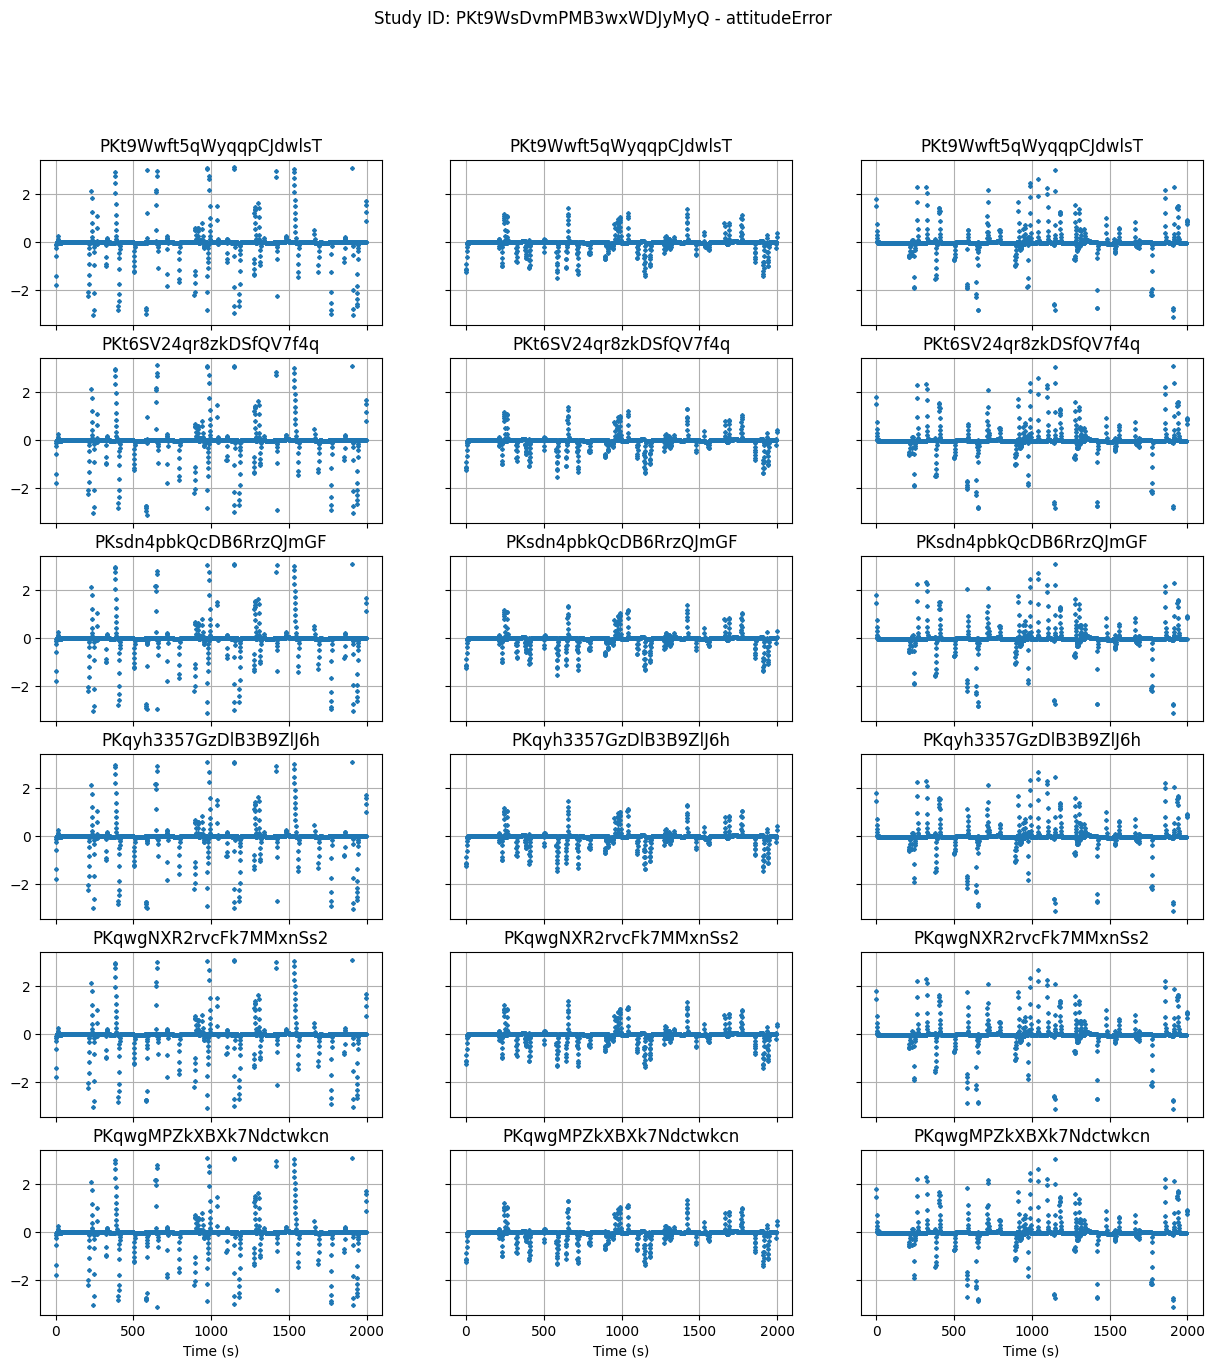

In [44]:
mc_study_Wildfire_agents.blocks("root").attitudeError.study_subplots(size=15,cols=3)

as expected, they are very simuliar with some small delta at the extremes. Lets take a look at the study histograms. Use the size parameter to scale the plots so the titles fit properly. I used a large number of bins to see more detail due to most of the values being close to zero.

array([[<Axes: title={'center': "('PKt9Wwft5qWyqqpCJdwlsT', 'attitudeError.0')"}>,
        <Axes: title={'center': "('PKt9Wwft5qWyqqpCJdwlsT', 'attitudeError.1')"}>,
        <Axes: title={'center': "('PKt9Wwft5qWyqqpCJdwlsT', 'attitudeError.2')"}>,
        <Axes: title={'center': "('PKt6SV24qr8zkDSfQV7f4q', 'attitudeError.0')"}>],
       [<Axes: title={'center': "('PKt6SV24qr8zkDSfQV7f4q', 'attitudeError.1')"}>,
        <Axes: title={'center': "('PKt6SV24qr8zkDSfQV7f4q', 'attitudeError.2')"}>,
        <Axes: title={'center': "('PKsdn4pbkQcDB6RrzQJmGF', 'attitudeError.0')"}>,
        <Axes: title={'center': "('PKsdn4pbkQcDB6RrzQJmGF', 'attitudeError.1')"}>],
       [<Axes: title={'center': "('PKsdn4pbkQcDB6RrzQJmGF', 'attitudeError.2')"}>,
        <Axes: title={'center': "('PKqyh3357GzDlB3B9ZlJ6h', 'attitudeError.0')"}>,
        <Axes: title={'center': "('PKqyh3357GzDlB3B9ZlJ6h', 'attitudeError.1')"}>,
        <Axes: title={'center': "('PKqyh3357GzDlB3B9ZlJ6h', 'attitudeError.2')"}>],
 

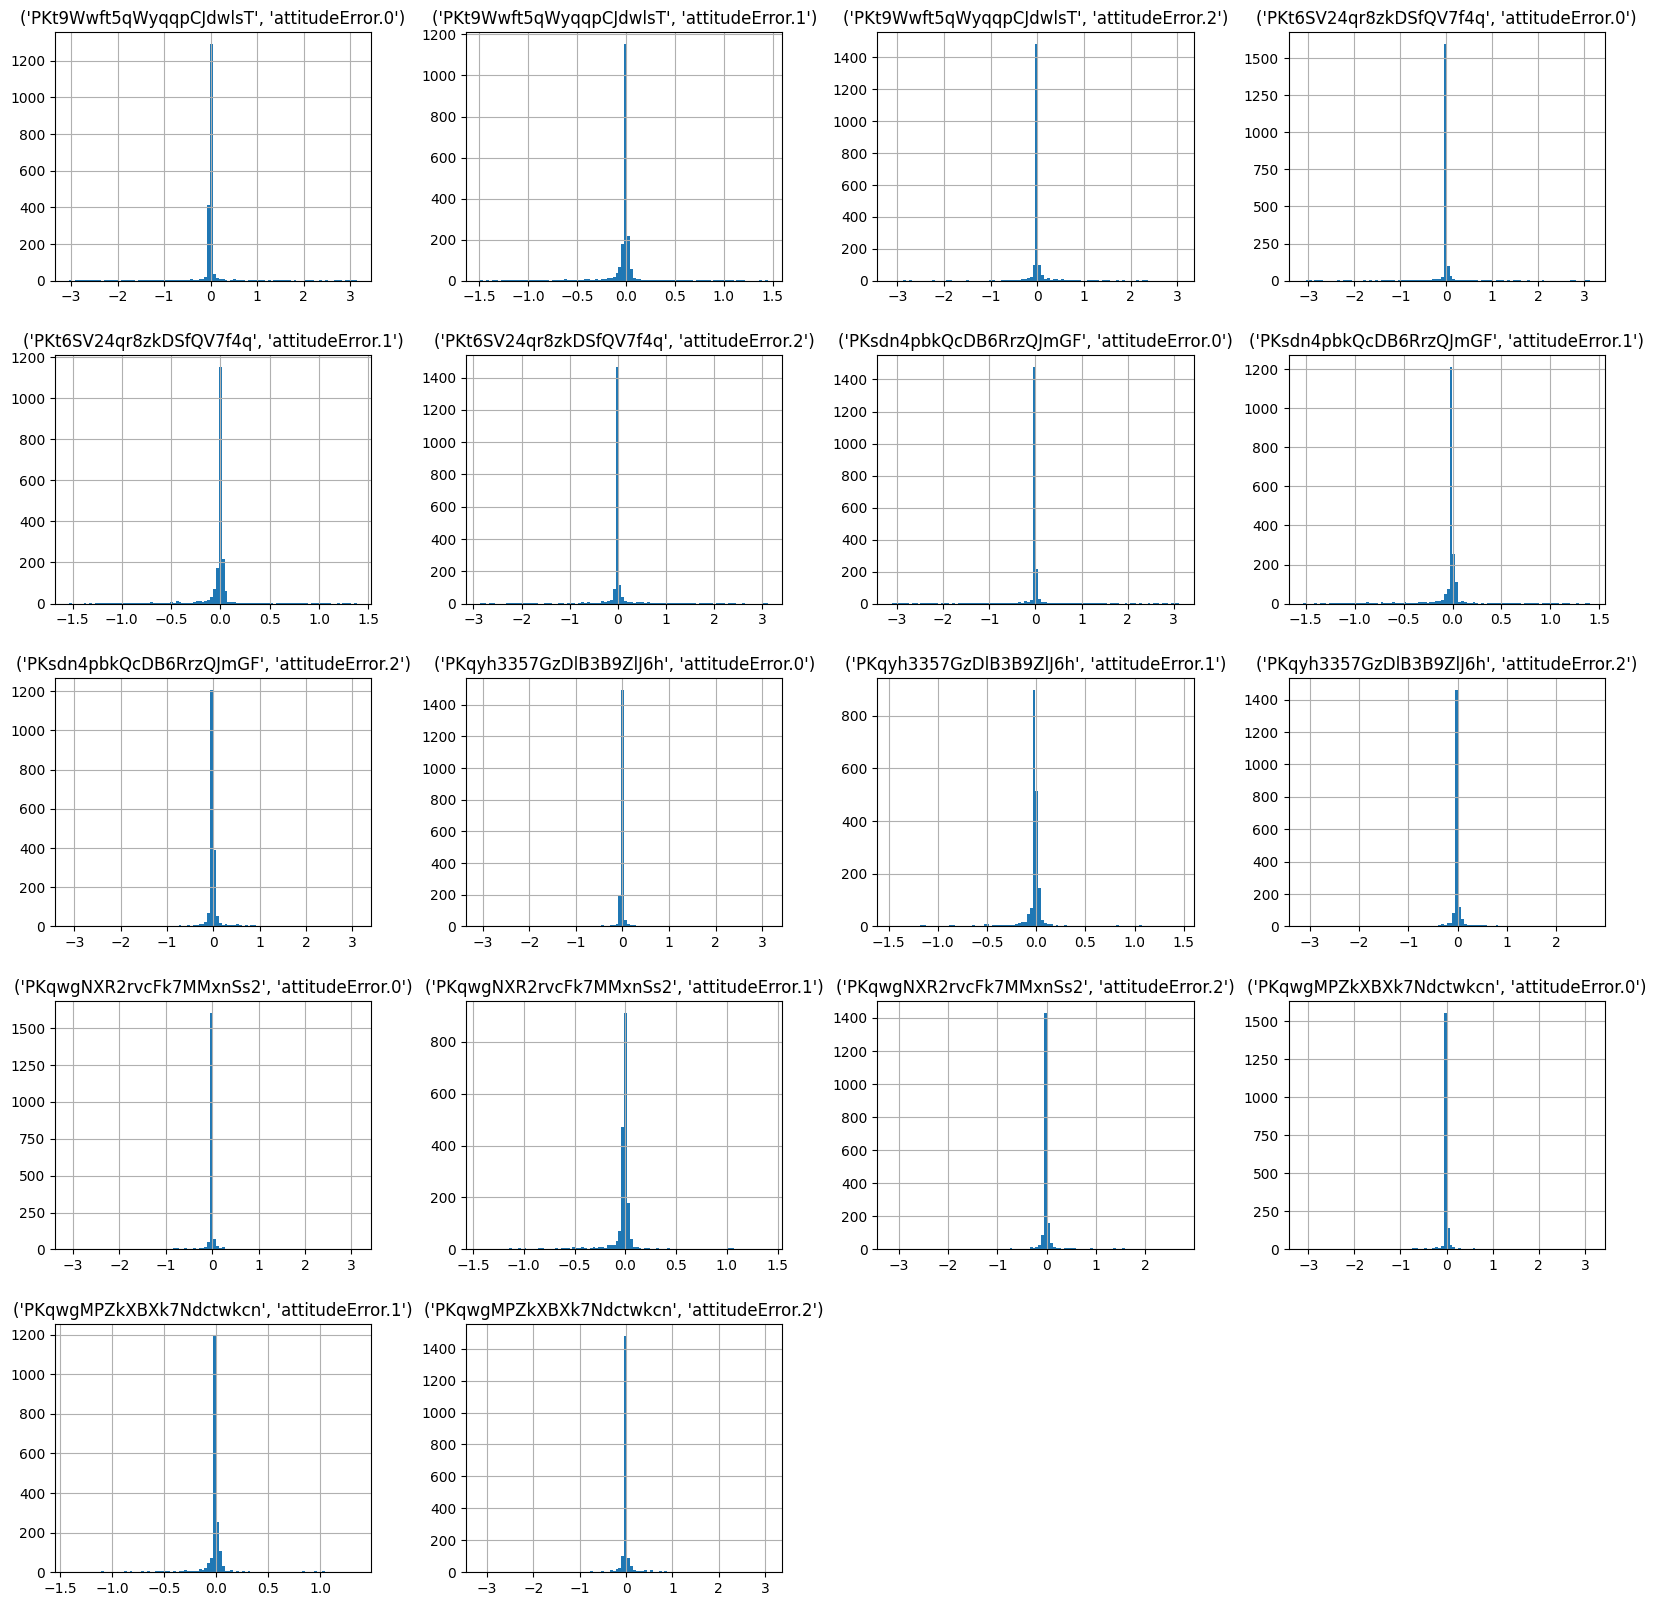

In [45]:
mc_study_Wildfire_agents.blocks("root").attitudeError.study_histogram()

Another way to compare the attitude error of all the simulations is to use a scatter_matrix.

Note: We are interested in roll <--> roll, pitch <--> pitch, and yaw <--> yaw comparistions: 
- So find the plot intersections of the 
  - attitudeError.0's for Roll
  - attitudeError.1's for Pitch and
  - attitudeError.2's for Yaw

Due to each simulation having different number of timesteps, this is not a perfect measure but they shoould be mostly linear lines from the bottom left corner to the top right. 

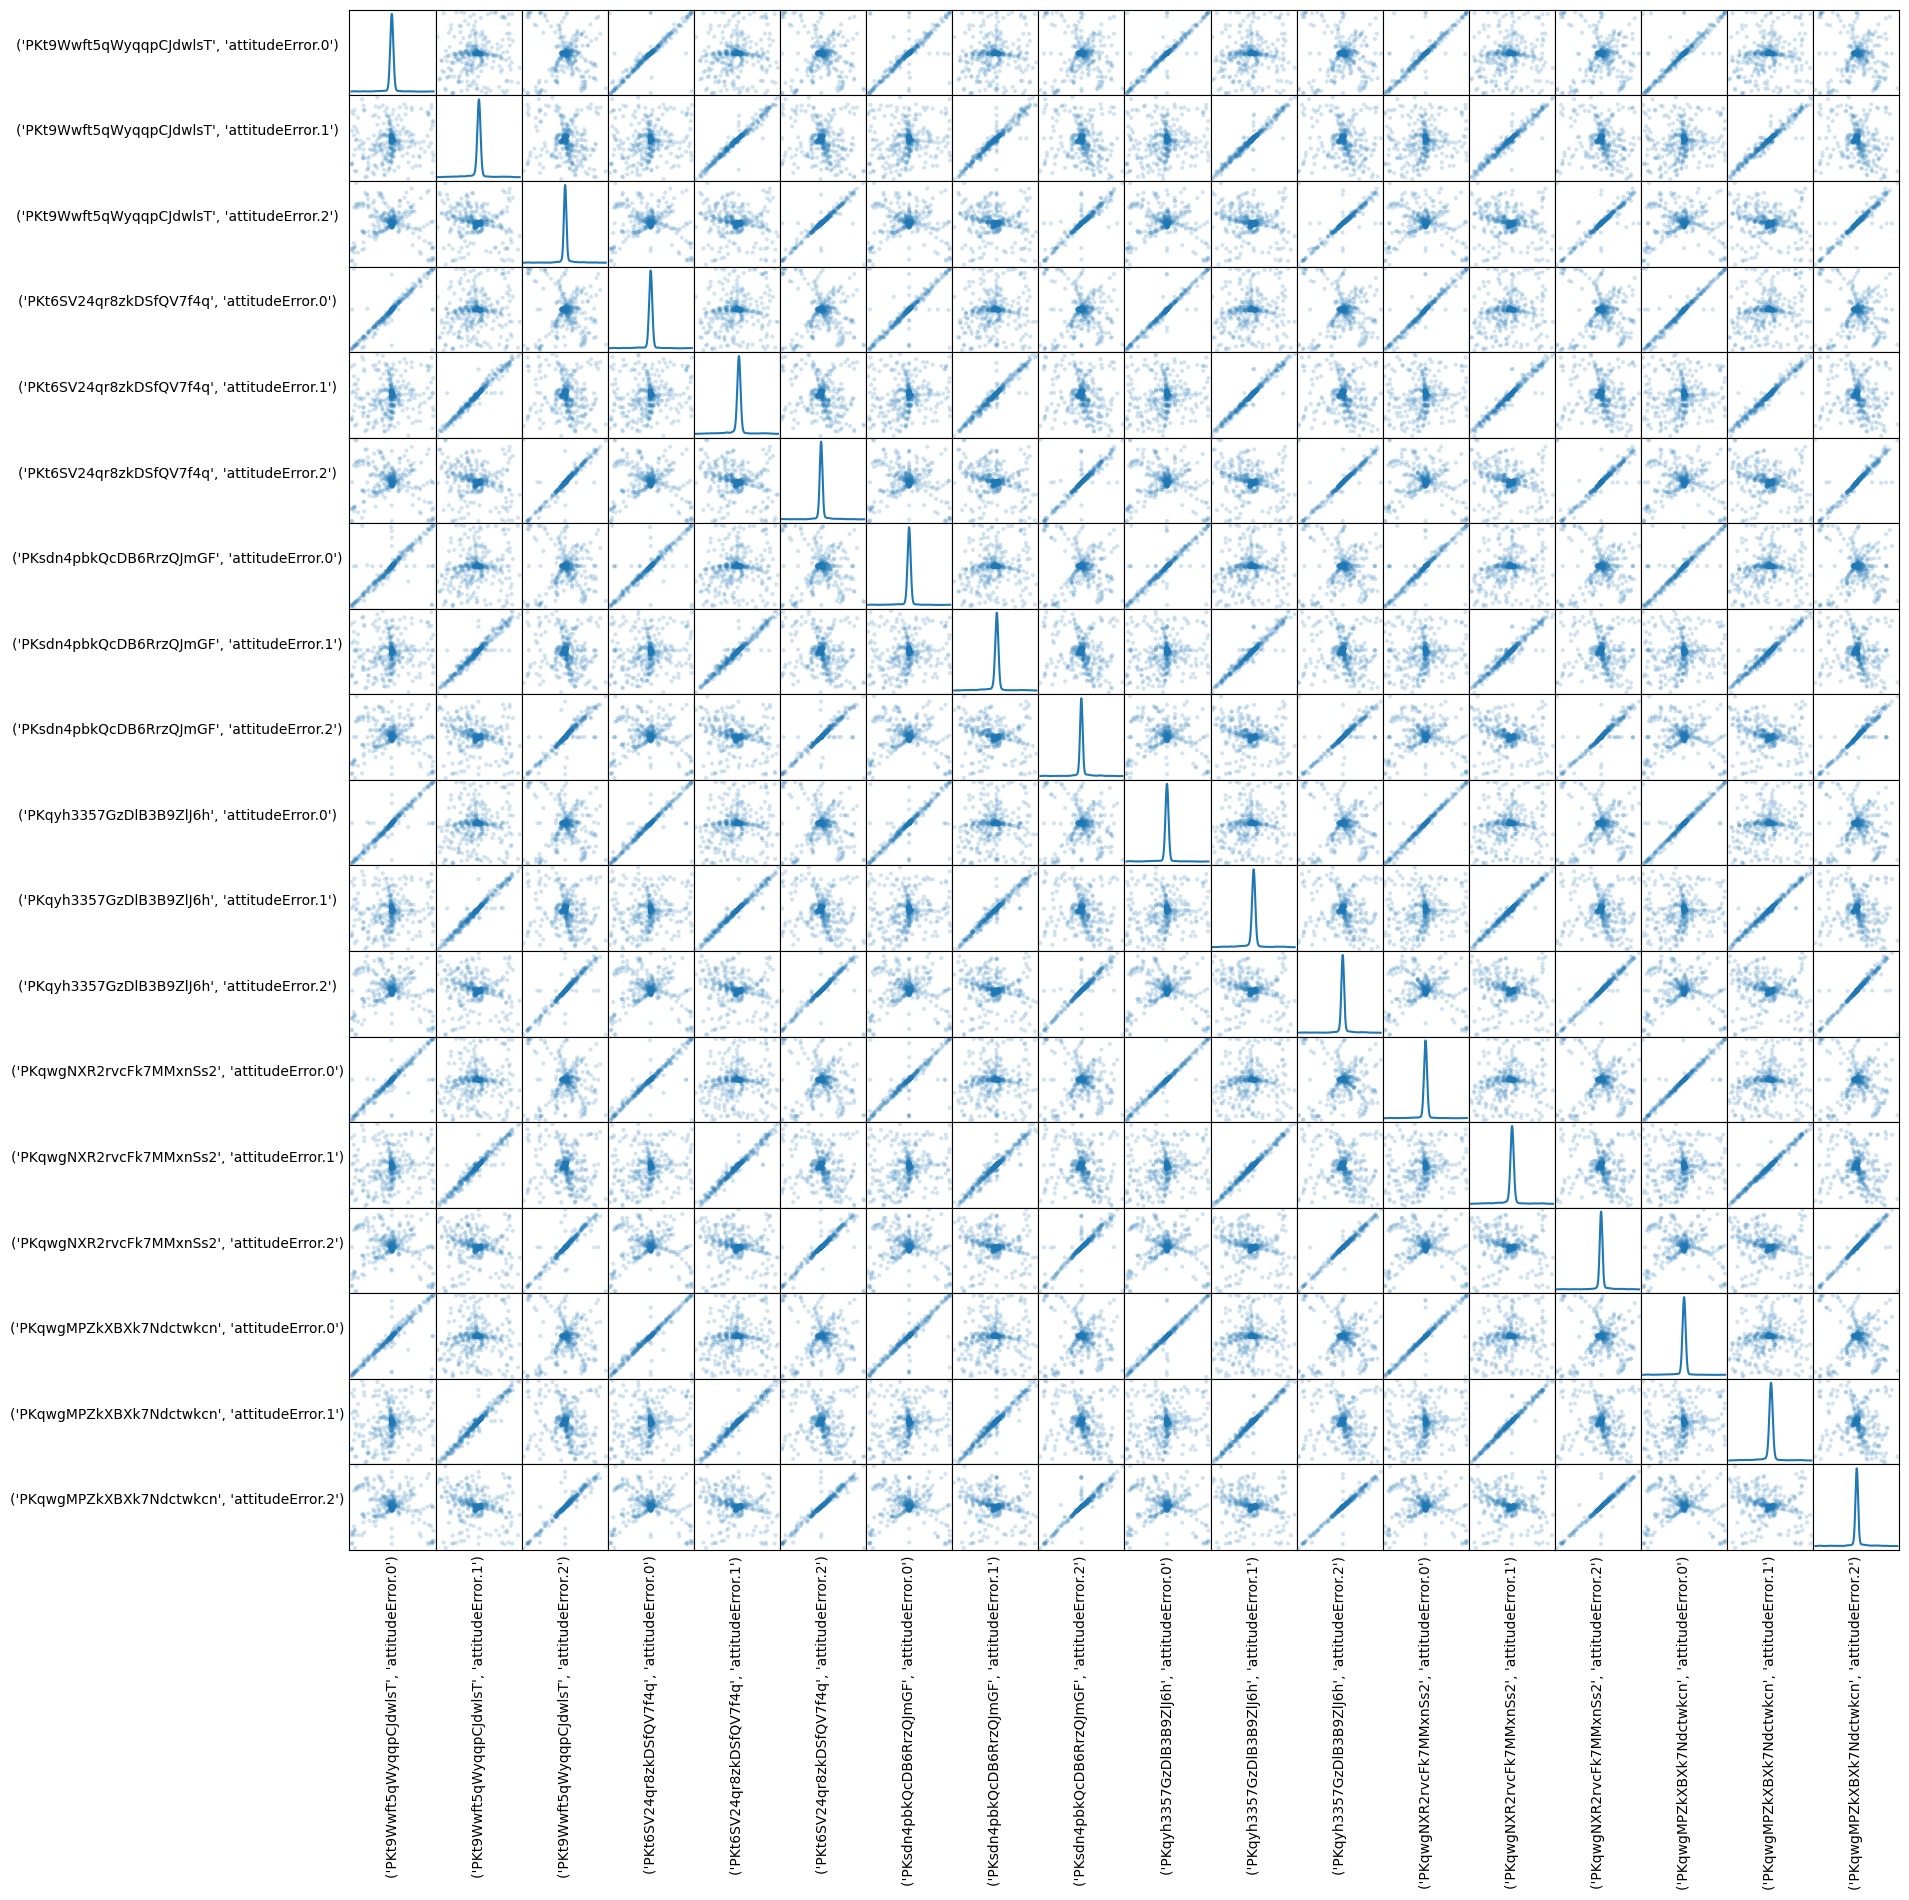

In [46]:
mc_study_Wildfire_agents.blocks("root").attitudeError.study_scatter_matrix(size=20)

Lets look at the angle between the attitude body and the commandAttitude quaternions. The included utils.py file contains some quaterion helper functions that we'll use. 

First lets make a dict of simulation_id to a np.array of body_eci quaternions(which are also a np.array). 

Basically a **Dict[str, np.array[np.array[float]]]**


In [47]:
import utils
simID_to_body_eci_quaternion = { sim_id: np.array(series.values) for (sim_id,series) in mc_study_Wildfire_agents.blocks("root").attitude.body_eci.items() }

Now lets look at the commandedAttitude output results for all the simulations of the study.

In [48]:
mc_study_Wildfire_agents.blocks("root").commandedAttitude.summarize()

---------------------------------------------------------------------------
                   Study Simulation Series Result Summary                  
                            'commandedAttitude'                            
                     Study ID: 'PKt9WsDvmPMB3wxWDJyMyQ'                    
---------------------------------------------------------------------------
                           Study Simulation ID's                           

 ['PKt9Wwft5qWyqqpCJdwlsT', 'PKt6SV24qr8zkDSfQV7f4q', 'PKsdn4pbkQcDB6RrzQJmGF', 'PKqyh3357GzDlB3B9ZlJ6h', 'PKqwgNXR2rvcFk7MMxnSs2', 'PKqwgMPZkXBXk7Ndctwkcn']
---------------------------------------------------------------------------
                    Study Simulation Series Data Summary                   
                            'commandedAttitude'                            
---------------------------------------------------------------------------
📈 sim_id:PKt9Wwft5qWyqqpCJdwlsT 2000 points covering 494.3 minutes with ~14.8s st

The commandedAttitude data type is also a list of the quaternions parameters. Lets make a another dict of sim_id to commandedAttitude quaternions 

In [49]:
simID_to_commandedAttitude_quaternion = { sim_id: np.array( [value for value in  series.values if value is not None]) for (sim_id,series) in mc_study_Wildfire_agents.blocks("root").commandedAttitude.values.items() }

now to calculate the angle between the commandedAttitude and the body_eci quaternion at each time step for each simulation of the study.

In [50]:
angle_between_them = { sim_id: [ utils.angleBetweenQuaternion(body,commanded) for (body,commanded) in zip(simID_to_body_eci_quaternion[sim_id], simID_to_commandedAttitude_quaternion[sim_id]) ]
                      for sim_id in simID_to_body_eci_quaternion.keys()
                       }

Due to each sim having a different number of results entries, use the following trick to add NaN to make them all the same size so it can be made into a pandas dataframe.

Note: We are not comparing each result index to other simuation due to the different timesteps and the Nan are filtered for the stat calculations

In [51]:
angle_between_them_df = pd.DataFrame.from_dict(angle_between_them, orient='index').T

In [52]:
angle_between_them_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PKt9Wwft5qWyqqpCJdwlsT,1999.0,0.296722,0.604531,0.005133,0.045034,0.046631,0.142728,3.133451
PKt6SV24qr8zkDSfQV7f4q,1999.0,0.305642,0.613287,0.004419,0.045313,0.046937,0.146182,3.120512
PKsdn4pbkQcDB6RrzQJmGF,1999.0,0.300973,0.608639,0.005032,0.045537,0.047172,0.142387,3.131723
PKqyh3357GzDlB3B9ZlJ6h,1999.0,0.301918,0.609301,0.004645,0.044759,0.046350,0.145285,3.120141
PKqwgNXR2rvcFk7MMxnSs2,1999.0,0.298014,0.603577,0.004324,0.045186,0.046851,0.142322,3.119511
PKqwgMPZkXBXk7Ndctwkcn,1999.0,0.301248,0.606876,0.005887,0.045302,0.046931,0.144415,3.119901


Note how the mean for each simulation run is closer to the 75% value due to the large spikes from goal orientation frequently changing 

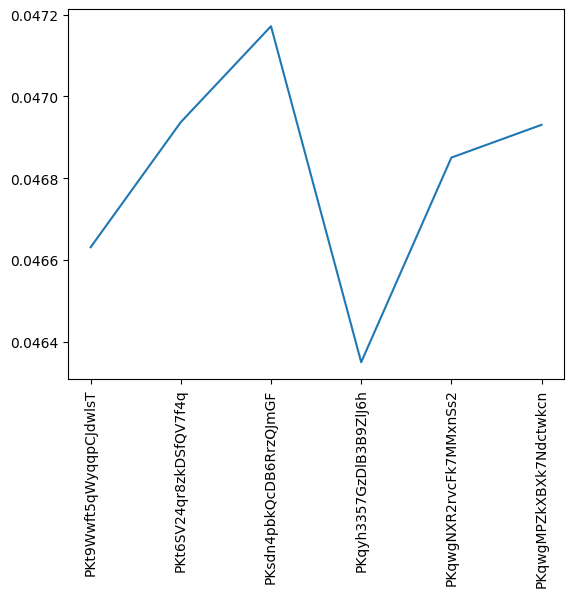

In [53]:
angle_between_them_df.describe().T['50%'].plot()
plt.xticks(rotation=90)
plt.show()